<h1><center>Applied Data Science Capstone</center></h1>

<h1>Project Name: Battle of the neighborhoods</h1>

Neighborhood segmentation and clustering to suggesst better one.
This notebook will be used to demonstrate skills I've learnt in IBM Data Science courses.

GitHub: https://github.com/arunnatarajan80/Coursera_Capstone

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import geocoder
from geopy.geocoders import Nominatim
import os
import warnings
warnings.filterwarnings('ignore')

# capstone_utilities is developed for this project specifically and same can be found in the github repository of this project
from capstone_utilities import getLocation, getNearbyVenues_Multi, getFoursquareCategories

# Data Collection

## Get Neighborhood and Location Coordinates
* Initial neighborhood names was manually collected as csv(cbe_neighborhoods.csv) from https://en.wikipedia.org/wiki/Neighbourhoods_of_Coimbatore
* Neighborhood Location Coordinates collected using geopy 

In [58]:
cbeNB = pd.read_csv('cbe_neighborhoods.csv') # Import Neighborhood Names
cbeNB = cbeNB.apply(getLocation, axis=1) # Get Location Coordinates
cbeNB.to_csv('cbe_nb_loc.csv', index=False) # Save collected data as csv
# Display collected data
print('# Neighborhoods:', cbeNB.shape[0])
print("# Neighborhoods with missing coordinates:", cbeNB['Latitude'].isnull().sum())
cbeNB.head(2)

# Neighborhoods: 64
# Neighborhoods with missing coordinates: 8


,Region,Neighborhood,Latitude,Longitude
0,North,Kavundampalayam,11.045235,76.94722
1,North,Chinnavedampatti,11.062943,76.98433


* 8 Neighborhoods are missing location coordinates.
* Probably reason for this is sources of Geopy library does not include or spelling issues.
* Manually collect coordinates for those and save output file as 'cbe_nb_loc_curated.csv'
  * Data Source for missing locations is google search
* Reload the data.

In [3]:
cbeNB = pd.read_csv('cbe_nb_loc_curated.csv')
print('# Neighborhoods:', cbeNB.shape[0])
print("# Neighborhoods with missing coordinates:", cbeNB['Latitude'].isnull().sum())
cbeNB.head(2)

# Neighborhoods: 64
# Neighborhoods with missing coordinates: 0


,Region,Neighborhood,Latitude,Longitude
0,North,Kavundampalayam,11.045235,76.94722
1,North,Chinnavedampatti,11.062943,76.98433


## Get Neighborhood Venue Details
* Data Source: Foursquare
* Collect venues using both "Explore" and "Search" endpoints

#### Foursquare API Setup and Utilities

<h5>
    <font color='red'>
        Foursquare API related functions are written separatly in to a python file and imported in this note book.
        capstone_utilities.py can be found in the github reporsitory.
    </font>
</h5>

#### Collect reccommended and browsed venues for each neighborhood

In [4]:
recommended = getNearbyVenues_Multi('explore', names=cbeNB['Neighborhood'], latitudes=cbeNB['Latitude'],
                        longitudes=cbeNB['Longitude'])
recommended.to_csv('recommendedVenues.csv', index=False)

searched = getNearbyVenues_Multi('search', names=cbeNB['Neighborhood'], latitudes=cbeNB['Latitude'],
                        longitudes=cbeNB['Longitude'])
searched.to_csv('browsedVenues.csv', index=False)

In [6]:
venueStatDf = pd.DataFrame(columns=['Endpoint', '# Neighborhoods', '# Venues', 
                                    '# Recommended Groups',
                                    '# Venue Categories',
                                    '# Uncategorized Venues'])

venueStatDf.loc[len(venueStatDf)] = ['Explore', len(recommended['Neighborhood'].unique()), recommended.shape[0],
                                     len(recommended['Recommendation Group Type'].unique()),
                                     len(recommended['Venue Category'].unique()),
                                     recommended['Venue Category'].isnull().sum()]

venueStatDf.loc[len(venueStatDf)] = ['Browse', len(searched['Neighborhood'].unique()), searched.shape[0],
                                     len(searched['Recommendation Group Type'].unique()),
                                     len(searched['Venue Category'].unique()),
                                     searched['Venue Category'].isnull().sum()]

print('# Neighborhoods:', cbeNB.shape[0])
venueStatDf.head()

# Neighborhoods: 64


,Endpoint,# Neighborhoods,# Venues,# Recommended Groups,# Venue Categories,# Uncategorized Venues
0,Explore,51,177,1,65,0
1,Browse,64,7472,1,368,376


#### Check if all recommended venus are found in search results, otherwise merge both

In [7]:
recommededNotInSearched = recommended[~(recommended['Venue Id'].isin(searched['Venue Id']))]
allVenues = searched.append(recommededNotInSearched)
print('# Recommended Venues missing in search Results:', recommededNotInSearched.shape[0])
print('# Venues after merge:', allVenues.shape[0])
allVenues.head(2)

# Recommended Venues missing in search Results: 28
# Venues after merge: 7500


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Recommendation Group Type,Recommendation Group Name,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,Kavundampalayam,11.045235,76.94722,Not Applicable,Not Applicable,Kavundampalayam,4f79a492e4b00df15d98eb12,11.044891,76.947559,Parking
1,Kavundampalayam,11.045235,76.94722,Not Applicable,Not Applicable,Sabari Bakery,5259e17f11d26f0160e95c89,11.042948,76.948176,Bakery


#### Drop Venues who name equals any of the neighborhoods Neighborhood
Since from above visualization we can notice from the first row that the Neighborhood and Venue Name are same
Such records are not useful for project objectives, hence drop them.

In [8]:
allVenues = allVenues[~(allVenues['Venue'].str.lower().isin(cbeNB['Neighborhood'].str.lower()))]
print(allVenues.shape)
allVenues.head(2)

(7459, 10)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Recommendation Group Type,Recommendation Group Name,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
1,Kavundampalayam,11.045235,76.94722,Not Applicable,Not Applicable,Sabari Bakery,5259e17f11d26f0160e95c89,11.042948,76.948176,Bakery
2,Kavundampalayam,11.045235,76.94722,Not Applicable,Not Applicable,Ayyappas Restaurant,4d5622e7cff7721e176cb2f5,11.045734,76.946890,NaN


## Get Venue Categories
* Foursquare Categories are organized as muti-level hierarchical structure
* For to simplify all further processing, categories will be collected in 2-Level hierarchy (Top Level, Children)
* Data Source: Foursquare
* Collect using "categories" endpoint

In [9]:
#fsCategories = getFoursquareCategories()
fsCategories = pd.read_excel('FoursquareCategories.xlsx')
print('# Top Level Categories:', len(fsCategories['Top Category'].unique()))
print('# Sub/Child Categories:', len(fsCategories['Sub Category'].unique()))
print('Length of Category DataFrame:', fsCategories.shape[0])
fsCategories.head(2)

# Top Level Categories: 10
# Sub/Child Categories: 933
Length of Category DataFrame: 933


,Top Category,Sub Category
0,Arts & Entertainment,Amphitheater
1,Arts & Entertainment,Aquarium


## Data Preparation / Refining Dataset

### Isolate Venue(Name) and Venue Category Columns
Rest of the columns in the collected data set would not be necessary for further analysis and modeling

In [10]:
baseData = allVenues[['Venue', 'Venue Category']]
baseData.columns = ['Venue', 'Category']
baseData.head(2)

,Venue,Category
1,Sabari Bakery,Bakery
2,Ayyappas Restaurant,NaN


### Split Dataset in to Uncategorized and Categorized Venues

In [11]:
uncategorized = baseData[baseData['Category'].isnull()]
categorized = baseData[~(baseData['Category'].isnull())]
print('# Uncategorized Venus:', uncategorized.shape[0])
print('# Categorized Venus:', categorized.shape[0])

# Uncategorized Venus: 370
# Categorized Venus: 7089


### Add Root Category (Top level category as per Foursquare Category Hierarchy)

In [12]:
def getRootCategory(row):
    #print(row['Category'])
    tc = fsCategories[fsCategories['Sub Category']==row['Category']]
    rootCategory = tc.iloc[0]['Top Category'] if len(tc) > 0 else row['Category']
    return rootCategory

categorized['RootCategory'] = categorized.apply(getRootCategory, axis=1)
categorized.head()

,Venue,Category,RootCategory
1,Sabari Bakery,Bakery,Food
3,Ayyappa's Pearl Wedding Hall,Event Space,Professional & Other Places
4,Thangam Arisi Mandi,Grocery Store,Shop & Service
5,Chandra Hyundai Service Centre,Automotive Shop,Shop & Service
6,Kalpana Theatre,Theater,Arts & Entertainment


# Exploratory Data Analysis

## Basic Summary of Dataset

In [13]:
print('# Venues:', categorized.shape[0])
print('# Categories:', len(categorized['Category'].unique()))
print('# Root Categories:', len(categorized['RootCategory'].unique()))

# Venues: 7089
# Categories: 368
# Root Categories: 10


## Visualize Categories

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def barPlot(x,y,title):
    fig = plt.figure(figsize=(15,5))
    ax = sns.barplot(x,y)#, alpha=0.8)
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(x, rotation=90)
    
    for patch in ax.patches:
        h = int(patch.get_height())
        w = patch.get_width()
        xpos = patch.get_x() + w/2
        ax.annotate('{}'.format(h), xy=(xpos, h), xytext=(0, 2),  textcoords="offset points", ha='center', va='bottom', fontsize=14)


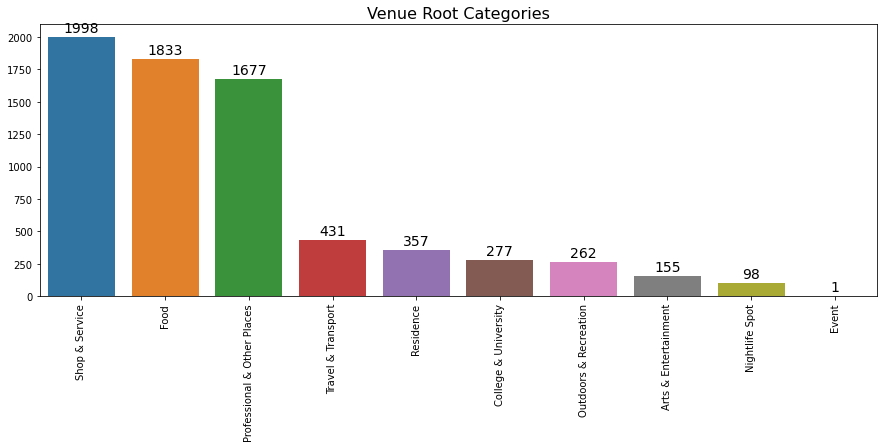

In [15]:
rootCategoryCounts = categorized.RootCategory.value_counts()
barPlot(rootCategoryCounts.index, rootCategoryCounts.values, 'Venue Root Categories')

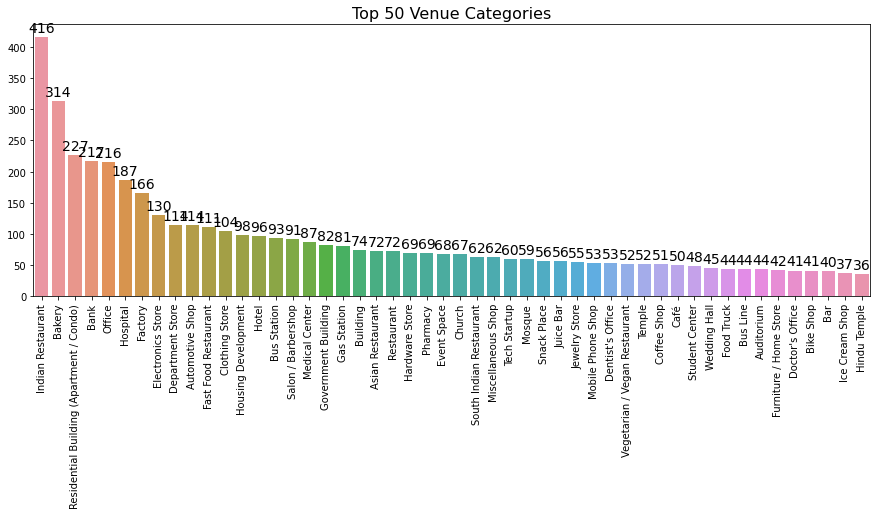

In [16]:
categoryCounts = categorized.Category.value_counts()
categoryCounts = categoryCounts[:50,]
barPlot(categoryCounts.index, categoryCounts.values, 'Top 50 Venue Categories')

## Imbalanced Category Distribution
Dataset is highly imbalanced amoung Categories and Root Categories, Inorder simplify the problem we could consider only root category as our final outcome and also drop "Event" RootCategory as there is only one occurance found

In [17]:
categorized.drop(columns='Category', inplace=True)
categorized = categorized[~(categorized.RootCategory == 'Event')]
print('# Venues:', categorized.shape[0])
print('# Root Categories:', len(categorized['RootCategory'].unique()))
categorized.head()

# Venues: 7088
# Root Categories: 9


,Venue,RootCategory
1,Sabari Bakery,Food
3,Ayyappa's Pearl Wedding Hall,Professional & Other Places
4,Thangam Arisi Mandi,Shop & Service
5,Chandra Hyundai Service Centre,Shop & Service
6,Kalpana Theatre,Arts & Entertainment


# Data Pre-Processing

## Dataset Split
Let us split the dataset using StratifiedShuffleSplit of sklearn so that we get balanced split amoung all classes
Tainset will have 90% of records and 10% will be used for testing

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
stratifiedShuffleSplitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
splitIndexData = stratifiedShuffleSplitter.split(categorized.Venue, categorized.RootCategory)

trainSet = pd.DataFrame()
testSet = pd.DataFrame()
for trainIndices, testIndices in splitIndexData:
    trainSet=categorized.iloc[trainIndices]
    testSet=categorized.iloc[testIndices]

print('Training Set Shape', trainSet.shape)
print('Testing Set Shape',testSet.shape)

Training Set Shape (5670, 2)
Testing Set Shape (1418, 2)


## Text Data Trsnformation using sklearn's TfidfVectorizer
#### TfidfVectorizer combines following steps
* First use Sklearn CountVectorizer to transform venue names to bag of words vector by which each word in venue name is counted full vocabulary of words from all Venue Names
* Second use Sklearn TfidfTransformer to transform the word count vector in to TF-IDF feature vector (For explanation of TF-IDF https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer().fit(trainSet.Venue)
Xtrain = tfidfVectorizer.transform(trainSet.Venue)
ytrain = trainSet.RootCategory.to_numpy(copy=True)
Xtest = tfidfVectorizer.transform(testSet.Venue)
ytest = testSet.RootCategory.to_numpy(copy=True)

# Classification Models
Following algorithms will be evaluated 
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

In [20]:
allModels = []

## K Nearest Neighbor(KNN)

### Prepare KNN Training and Validation Datasets

In [21]:
knnTrainX = None
knnTrainY = None
knnValidationX = None
knnValidationY = None
knnSplit = stratifiedShuffleSplitter.split(Xtrain, ytrain)
for knnTrainIndices, knnValidationIndices in knnSplit:
    knnTrainX=Xtrain[knnTrainIndices]
    knnTrainY=ytrain[knnTrainIndices]
    knnValidationX=Xtrain[knnValidationIndices]
    knnValidationY=ytrain[knnValidationIndices]

print('KNN Training Set Shape', knnTrainX.shape)
print('KNN Validation Set Shape', knnValidationX.shape)

KNN Training Set Shape (4536, 3347)
KNN Validation Set Shape (1134, 3347)


### Train KNN Models for a range of K Values

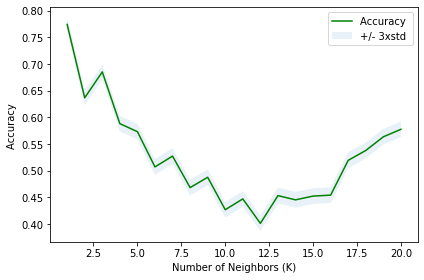

Best K=1 at Validation Accuracy=0.77...!!!
# Models: 1


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
k_max = 20
mean_acc = np.zeros(k_max)
std_acc = np.zeros(k_max)
models = []
for numNeighbors in range(1,k_max+1): # k_max +1 is used because range() does not include the stop value
    #Train Model and Predict  
    knnClf = KNeighborsClassifier(n_neighbors = numNeighbors).fit(knnTrainX, knnTrainY)
    yhat=knnClf.predict(knnValidationX)
    mean_acc[numNeighbors-1] = metrics.accuracy_score(knnValidationY, yhat)
    std_acc[numNeighbors-1]=np.std(yhat==knnValidationY)/np.sqrt(yhat.shape[0])
    models.append(knnClf)

# Plot Accuracy Change over increasing K
plt.plot(range(1,k_max+1),mean_acc,'g')
plt.fill_between(range(1,k_max+1), mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# Get the best accuracy, K, and Model
bestAccuracy = mean_acc.max()
bestK = mean_acc.argmax()+1
bestKnnModel = models[bestK-1]
bestKnnDescription = 'Best K={} at Validation Accuracy={}'.format(bestK, round(bestAccuracy, 2))
print(bestKnnDescription+'...!!!')

# Store it in all models dictionary
allModels.append({'Algorithm':'KNN','Description' : bestKnnDescription, 'Model': bestKnnModel})
print('# Models:', len(allModels))

## Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier(criterion="entropy")
decisionTree.fit(Xtrain,ytrain)
allModels.append({'Algorithm':'Decision Tree','Description' : 'criterion=Entropy', 'Model': decisionTree})
print('Built Decision Tree Model...!!!')
print('# Models:', len(allModels))

Built Decision Tree Model...!!!
# Models: 2


## Support Vector Machine

In [24]:
from sklearn import svm
kernels = ['linear', 'rbf', 'sigmoid']
for kernal in kernels:
    svmClf = svm.SVC(kernel=kernal)
    svmClf.fit(Xtrain,ytrain)
    allModels.append({'Algorithm':'SVM','Description' : 'kernel={}'.format(kernal), 'Model': svmClf})

print('Built SVM Classifiers with kernals={}...!!!'.format(kernels))
print('# Models:', len(allModels))

Built SVM Classifiers with kernals=['linear', 'rbf', 'sigmoid']...!!!
# Models: 5


## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
for solver in solvers:
    lr = LogisticRegression(C=0.01, solver=solver).fit(Xtrain,ytrain)
    allModels.append({'Algorithm':'LogisticRegression','Description' : 'solver={}, C=0.01'.format(solver), 'Model': lr})

print('Built Logistic Regression Classifiers with solvers={}...!!!'.format(kernels))
print('# Models:', len(allModels))

Built Logistic Regression Classifiers with solvers=['linear', 'rbf', 'sigmoid']...!!!
# Models: 10


# Model Evaluation using Test set

## Calculate Evaluation Metrics 
For each model using test dataset

In [26]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

for ind, modelData in enumerate(allModels):
    testModel = modelData ['Model']
    yhat = testModel.predict(Xtest)
    jsScore = jaccard_similarity_score(ytest, yhat)
    modelData['Jaccard'] = jsScore
    f1Score = f1_score(ytest, yhat, average='weighted')
    modelData['F1-score'] = f1Score
    
    if modelData['Algorithm'] == 'LogisticRegression':
        yhat_prob = testModel.predict_proba(Xtest)
        logLoss = log_loss(ytest, yhat_prob)
        modelData['LogLoss'] = logLoss
        
    allModels[ind] = modelData

allModels = pd.DataFrame(allModels) # Convert the Test Metrics Data in to DataFrame
report = allModels[['Algorithm', 'Jaccard','F1-score','LogLoss', 'Description']] # Select only report columns
report = report.loc[report.groupby(['Algorithm'])['F1-score'].idxmax()] # select only top performing model for each algorithm
report.sort_values('F1-score', ascending=False, inplace=True)
report.reset_index(drop=True, inplace=True) # reset index

print('Computed metrics for all models using test dataset...!!!')

Computed metrics for all models using test dataset...!!!


,Algorithm,Jaccard,F1-score,LogLoss,Description
0,SVM,0.877292,0.875764,NaN,kernel=rbf
1,Decision Tree,0.861777,0.861950,NaN,criterion=Entropy
2,KNN,0.813822,0.815391,NaN,Best K=1 at Validation Accuracy=0.77
3,LogisticRegression,0.428773,0.354079,1.691702,"solver=newton-cg, C=0.01"


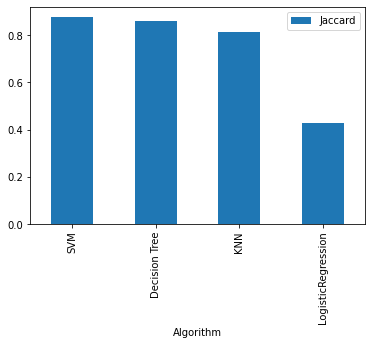

In [27]:
report.plot(x='Algorithm', y='Jaccard', kind='bar')
report.head()

## Further Evaluating Best Model with Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix of SVM')

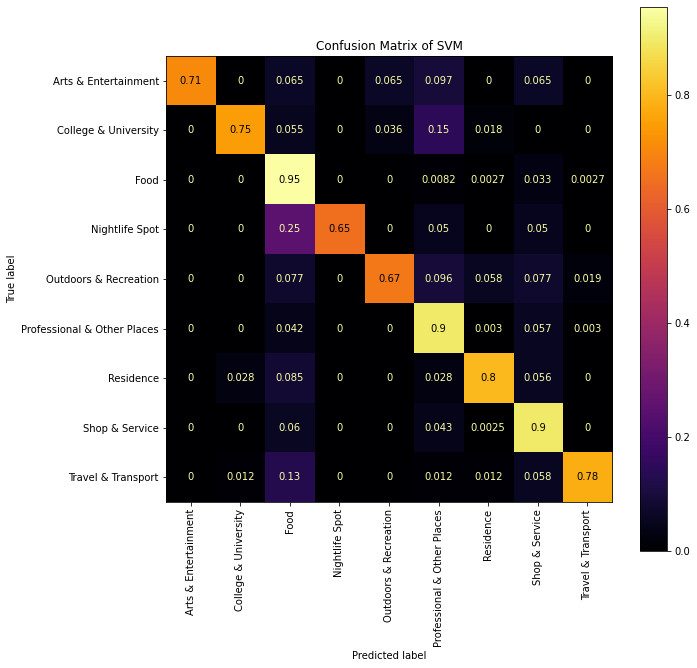

In [35]:
from sklearn.metrics import plot_confusion_matrix

bestModelTitle = allModels.loc[allModels['Jaccard'].idxmax(), 'Algorithm'] 
bestModel = allModels.loc[allModels['Jaccard'].idxmax(), 'Model'] 

fig = plt.figure(figsize=(10,10))
axnorm = fig.add_subplot(111)
confMatPlotNorm = plot_confusion_matrix(bestModel, Xtest, ytest, ax=axnorm, normalize='true', cmap='inferno', xticks_rotation='vertical')
confMatPlotNorm.ax_.set_title('Confusion Matrix of {}'.format(bestModelTitle))


#### Major chunk of accuracy loss happens due to misclassification of "Nightlife Spot"(Expected) as "Food"(Predicted)

# Further Exploring on mis-classifications

In [46]:
ypred = bestModel.predict(Xtest)
testSet['Predicted'] = ypred
testSet.columns=['Venue', 'Expected', 'Predicted']
misclf = testSet[testSet['Expected'] != testSet['Predicted']]
misclf.head()

,Venue,Expected,Predicted
3199,mo finissh,Professional & Other Places,Food
5676,G3 water Doctor,Food,Professional & Other Places
1841,Kalanikethan,Shop & Service,Food
5186,Boat house,Arts & Entertainment,Food
631,Spartan,Shop & Service,Food


In [51]:
     
extract = misclf[(misclf['Expected'] == 'Nightlife Spot') | (misclf['Expected'] == 'Food') | (misclf['Expected'] == 'Shop & Service')]

In [57]:
pd.set_option('display.max_rows', None)
extract

,Venue,Expected,Predicted
5676,G3 water Doctor,Food,Professional & Other Places
1841,Kalanikethan,Shop & Service,Food
631,Spartan,Shop & Service,Food
5144,saraswati hospital,Shop & Service,Professional & Other Places
6119,Paatiamma Pottikadai,Shop & Service,Food
2329,K.M.M Fish Stall,Shop & Service,Food
1402,Compu Soft Systems,Shop & Service,Professional & Other Places
605,kovai pazhamudir,Shop & Service,Food
6521,Black Box,Nightlife Spot,Food
5143,Arafa JAS Briyani Hall,Food,Professional & Other Places
